Using device: cuda
Epoch [1/5], Loss: 0.1861
Epoch [2/5], Loss: 0.0494
Epoch [3/5], Loss: 0.0351
Epoch [4/5], Loss: 0.0261
Epoch [5/5], Loss: 0.0190
Test Accuracy: 98.91%
Model saved.
Initial prediction: 4
Prediction after attack: 4


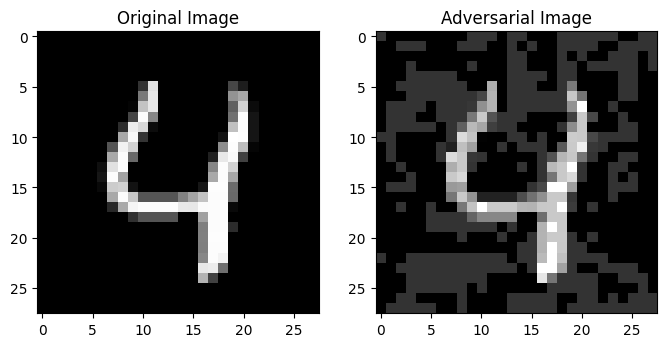

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F   # <--- ADD THIS
import matplotlib.pyplot as plt

#GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#  DATA TRANSFORMS/LOAD DATASETS
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets - to be done in the training loop later
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (batch_size, 32, 28, 28)
        x = F.max_pool2d(x, 2, 2)  # (batch_size, 32, 14, 14)
        x = F.relu(self.conv2(x))  # (batch_size, 64, 14, 14)
        x = F.max_pool2d(x, 2, 2)  # (batch_size, 64, 7, 7)
        x = x.view(-1, 7*7*64)     # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# LOSS & OPTIMIZER
model = SimpleCNN().to(device)  # Ensure model is on the correct device
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#TRAINING LOOP
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Ensure images and labels are on the same device

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

#EVALUATE 
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Ensure images and labels are on the same device
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")
torch.save(model.state_dict(), "simple_cnn_mnist.pth")
print("Model saved.")

#FGSM ATTACK FUNCTION
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("simple_cnn_mnist.pth"))
model.eval()

# FGSM attack function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Attack one image
target_label = 4
epsilon = 0.2  # Lower epsilon value to reduce the chances of instability

# Find a '4' in the test set
for data, target in test_loader:
    data, target = data.to(device), target.to(device)  # Ensure data is on the same device as model
    idx = (target == target_label).nonzero(as_tuple=True)[0]
    if len(idx) > 0:
        image = data[idx[0]].unsqueeze(0).to(device)  # Ensure image is on the same device as model
        label = target[idx[0]].unsqueeze(0).to(device)  # Ensure label is on the same device
        break

# Ensure the image has requires_grad set
image.requires_grad = True

# Forward pass to get initial prediction
output = model(image)
init_pred = output.max(1, keepdim=True)[1]

if init_pred.item() != target_label:
    print("The model did not classify this image as", target_label)
else:
    # Compute loss
    loss = criterion(output, label)
    
    # Backward pass to compute gradients
    model.zero_grad()
    loss.backward()
    
    # Collect gradients
    data_grad = image.grad.data

    # Perform FGSM attack
    perturbed_image = fgsm_attack(image, epsilon, data_grad)

    # Re-classify the perturbed image
    output = model(perturbed_image)
    final_pred = output.max(1, keepdim=True)[1]

    print(f"Initial prediction: {init_pred.item()}")
    print(f"Prediction after attack: {final_pred.item()}")

    # Plot the original and perturbed images
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze().detach().cpu().numpy(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("Adversarial Image")
    plt.imshow(perturbed_image.squeeze().detach().cpu().numpy(), cmap="gray")
    plt.show()


Using device: cuda
Epoch [1/5], Loss: 0.1652
Epoch [2/5], Loss: 0.0478
Epoch [3/5], Loss: 0.0319
Epoch [4/5], Loss: 0.0230
Epoch [5/5], Loss: 0.0178
Test Accuracy: 99.00%
Model saved.
Initial prediction: 4
Prediction after attack: 9


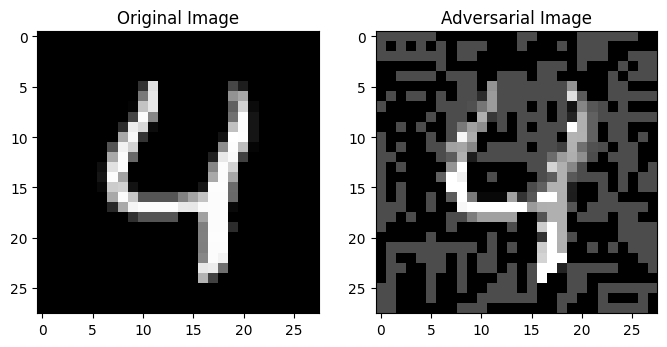

In [14]:
# STEP 1: IMPORT LIBRARIES
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F   # <--- ADD THIS
import matplotlib.pyplot as plt

# STEP 2: SET DEVICE (USE GPU IF AVAILABLE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# STEP 3: DEFINE DATA TRANSFORMS AND LOAD DATASETS
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets and ensure they are moved to the correct device (this will be done in the training loop later)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# STEP 4: DEFINE A SIMPLE CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (batch_size, 32, 28, 28)
        x = F.max_pool2d(x, 2, 2)  # (batch_size, 32, 14, 14)
        x = F.relu(self.conv2(x))  # (batch_size, 64, 14, 14)
        x = F.max_pool2d(x, 2, 2)  # (batch_size, 64, 7, 7)
        x = x.view(-1, 7*7*64)     # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# STEP 5: DEFINE LOSS FUNCTION AND OPTIMIZER
model = SimpleCNN().to(device)  # Ensure model is on the correct device
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# STEP 6: TRAINING LOOP
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Ensure images and labels are on the same device

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# STEP 7: EVALUATE AND SAVE MODEL
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Ensure images and labels are on the same device
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")
torch.save(model.state_dict(), "simple_cnn_mnist.pth")
print("Model saved.")

# STEP 8: FGSM ATTACK FUNCTION
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("simple_cnn_mnist.pth"))
model.eval()

# FGSM attack function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Attack one image
target_label = 4
epsilon = 0.3  # Lower epsilon value to reduce the chances of instability

# Find a '4' in the test set
for data, target in test_loader:
    data, target = data.to(device), target.to(device)  # Ensure data is on the same device as model
    idx = (target == target_label).nonzero(as_tuple=True)[0]
    if len(idx) > 0:
        image = data[idx[0]].unsqueeze(0).to(device)  # Ensure image is on the same device as model
        label = target[idx[0]].unsqueeze(0).to(device)  # Ensure label is on the same device
        break

# Ensure the image has requires_grad set
image.requires_grad = True

# Forward pass to get initial prediction
output = model(image)
init_pred = output.max(1, keepdim=True)[1]

if init_pred.item() != target_label:
    print("The model did not classify this image as", target_label)
else:
    # Compute loss
    loss = criterion(output, label)
    
    # Backward pass to compute gradients
    model.zero_grad()
    loss.backward()
    
    # Collect gradients
    data_grad = image.grad.data

    # Perform FGSM attack
    perturbed_image = fgsm_attack(image, epsilon, data_grad)

    # Re-classify the perturbed image
    output = model(perturbed_image)
    final_pred = output.max(1, keepdim=True)[1]

    print(f"Initial prediction: {init_pred.item()}")
    print(f"Prediction after attack: {final_pred.item()}")

    # Plot the original and perturbed images
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze().detach().cpu().numpy(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("Adversarial Image")
    plt.imshow(perturbed_image.squeeze().detach().cpu().numpy(), cmap="gray")
    plt.show()
